# Video Pipeline Demonstrating Applying Labels Based on Timestamps or Frame Numbers

In this example, we will use the [readers.Video](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.readers.Video.html) operator to read videos along with their labels. We will apply labels to the video based on frame numbers as input, and read timestamp and frame number labels along with decoded video frames.

For more information on the `readers.Video` parameters, please refer to the documentation.

First let's import the libraries.

In [1]:
import os
import tempfile
from pathlib import Path

import nvidia.dali.experimental.dynamic as ndd
import nvidia.dali.types as types

We define that we want a batch size of 4 and each sequence has a length of 1 frame. We will run 10 iterations for illustrative purposes.

In [2]:
batch_size = 4
sequence_length = 1
num_iterations = 10
frame_num_based_labels = True

The video we use in this example is 10 seconds long, 25fps, with 512x512 resolution. It has the timestamp burned into the top half of the frame and the frame number in the bottom half. The burned text in the decoded frame can be used to verify that we receive the correct frame number and timestamp labels.

<div class="alert alert-info">

   Note<br>

   `DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.
</div>

In [3]:
dali_extra_path = Path(os.environ["DALI_EXTRA_PATH"])
video_path = dali_extra_path / "db" / "video" / "test_label.mp4"

file_list_txt = f"{video_path} 0 0 100\n"
file_list_txt += f"{video_path} 1 100 200\n"
file_list_txt += f"{video_path} 2 200 250\n"

tf = tempfile.NamedTemporaryFile(mode="w", delete=True)
tf.write(file_list_txt)
tf.flush()
file_list_path = tf.name

## Creating the Reader

We create a [readers.Video](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.readers.Video.html) reader that will output the video frames along with their labels, frame numbers, and timestamps.

Notice that we set `file_list_frame_num=True`, which means the labels we provided above using `file_list` will be interpreted as frame numbers.
`test_label.mp4 0 0 100` is interpreted as applying label 0 from frame number 0 to 100 (excluding).

If however you wished to apply labels using timestamp, simply set `file_list_frame_num=False`, and provide timestamps you wish to apply the label to. For example, if you wished to apply a label 1 to frames from 3 seconds to 8.5 seconds: `test_label.mp4 1 3 8.5`.

In this example we have set both `enable_frame_num` and `enable_timestamps` to `True` for illustrative purposes. You can enable or disable either of them depending on your use case.

In [4]:
reader = ndd.readers.Video(
    device="gpu",
    file_list=file_list_path,
    sequence_length=sequence_length,
    shard_id=0,
    num_shards=1,
    random_shuffle=True,
    initial_fill=10,
    image_type=types.RGB,
    dtype=ndd.uint8,
    file_list_frame_num=frame_num_based_labels,
    enable_frame_num=True,
    enable_timestamps=True,
    file_list_include_preceding_frame=True,
)

## Visualizing the Results

We use matplotlib to display the frames and their associated labels.

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

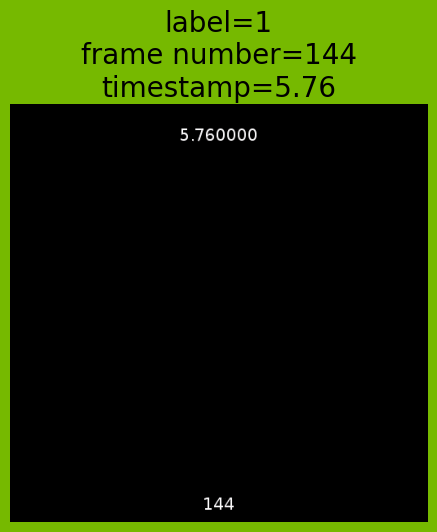

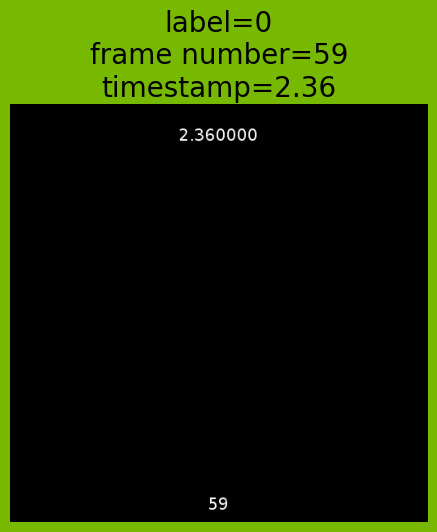

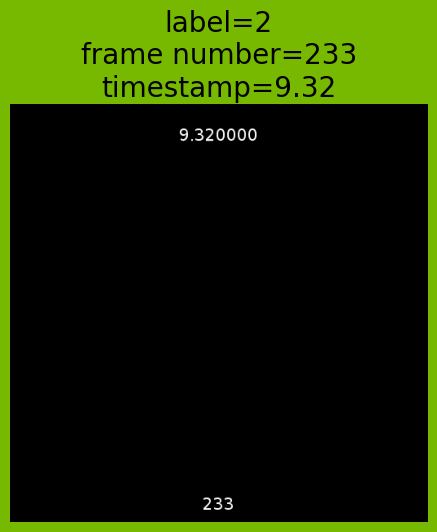

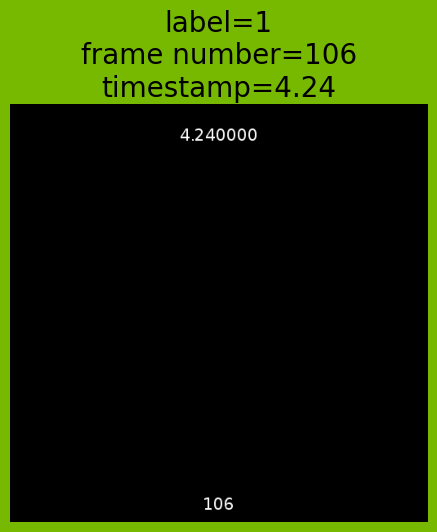

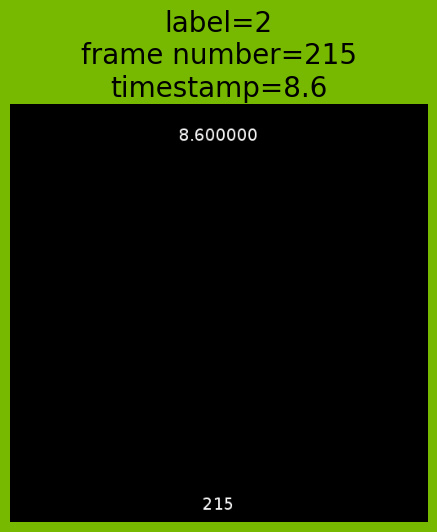

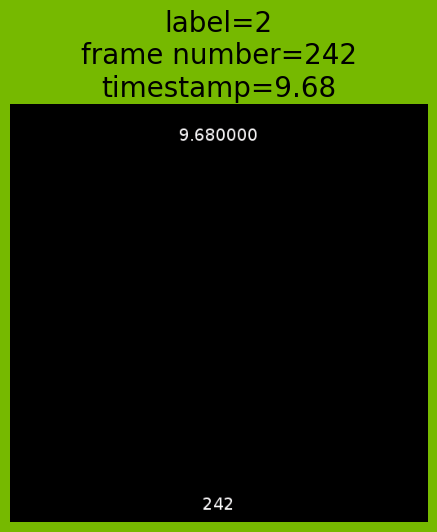

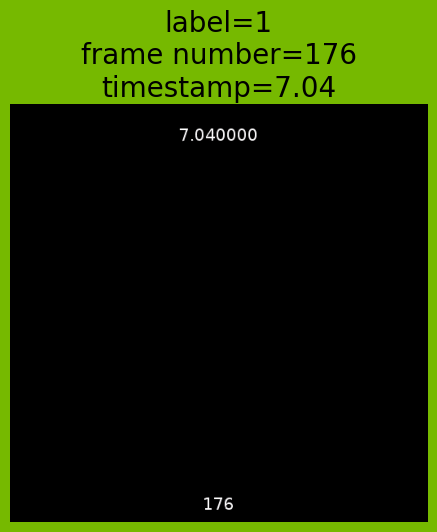

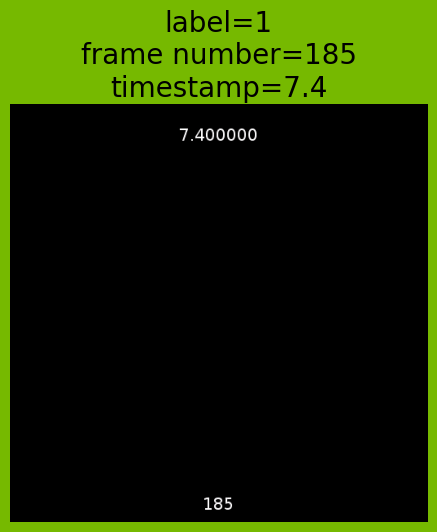

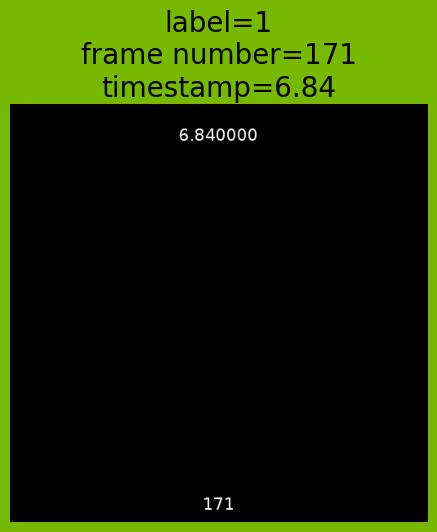

In [6]:
import numpy as np

gs = gridspec.GridSpec(num_iterations, 1)

for i, (videos, labels, frame_numbers, timestamps) in enumerate(
    reader.next_epoch(batch_size=batch_size)
):
    if i >= num_iterations:
        break

    # Get first sample from each batch (moved to CPU)
    video = videos.select(0).cpu()
    label = labels.select(0).cpu()
    frame_num = frame_numbers.select(0).cpu()
    timestamp = timestamps.select(0).cpu()

    # Get the first frame from the sequence
    sample_frame = video[0]

    fig = plt.figure(figsize=(16, 64), facecolor="#76b900")
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(
        f"label={label[0].item()}\n"
        f"frame number={frame_num[0].item()}\n"
        f"timestamp={round(timestamp[0].item(), 2)}",
        fontsize=20,
    )
    plt.imshow(sample_frame)

plt.close()
tf.close()